In [ ]:
!pip install sklearn

In [6]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from compare_wandb import load_full_df, get_test_pdbs, load_run_dict

import wandb
api = wandb.Api()
entity = 'proteins'
project = 'iclr2021-rebuttal'

import boto3
import os
s3 = boto3.client("s3")
s3_bucket = "proteindata"

import torch


from mogwai import models
from mogwai.utils.functional import apc
model_name = 'factored_attention'
fatt_model = models.get(model_name)
gremlin_model = models.get('gremlin')

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from scipy.stats import spearmanr
from scipy.stats import pearsonr

import pickle as pkl
from mogwai.parsing import read_contacts
from mogwai.metrics import precisions_in_range



def parse_pdb(filename):
    return filename.split('.')[0]

In [7]:
gremlin_runs = {'gremlin': 'dbuvl02g'}
gremlin_df_dict = load_run_dict(gremlin_runs)
gremlin_df = pd.concat(list(gremlin_df_dict.values()))

100%|██████████| 748/748 [00:00<00:00, 23387.32it/s]

dbuvl02g has 748 runs


In [145]:
# for fun look at the histogram
# compute precisions

num_residue_contacts = []
num_total_contacts = []
l = []

rows = []

# iterate over all the npz files in the trrosetta dataset
for root, dirs, files in os.walk("data/npz", topdown=False):
    for filename in tqdm(files):

        pdb = parse_pdb(filename)
        npz_filename = f'data/npz/{pdb}.npz'
        targets = torch.from_numpy(read_contacts(npz_filename))
        
        fam_data = np.load(npz_filename)
        # pull first sequence out
        residue_identity = fam_data["msa"][0, :]
        masked_targets = np.triu(targets, 6)
        
        num_contacts = np.count_nonzero(masked_targets)
        L = masked_targets.shape[0]
        residue_contacts = np.count_nonzero(masked_targets, axis=0)
        for i in range(masked_targets.shape[0]):
            data = {}
            data['pdb'] = pdb
            data['L'] = L
            data['num_total_contacts'] = num_contacts
            data['num_residue_contacts'] = residue_contacts[i]
            data['aa'] = residue_identity[i]
            rows.append(data)
            num_residue_contacts.append(data['num_residue_contacts'])
        num_total_contacts.append(num_contacts)
        l.append(L)

num_residue_contacts = np.array(num_residue_contacts)
num_total_contacts = np.array(num_total_contacts)
l = np.array(l)

contacts_df = pd.DataFrame.from_records(rows)

100%|██████████| 15051/15051 [03:07<00:00, 80.14it/s] 


In [187]:


ALPHABET = "ARNDCQEGHILKMFPSTWYV-"
N2A = {n: a for n, a in enumerate(ALPHABET)}
polar = 'STYNCQH'
hydrophobic = 'GALVIMPFW'
charged = 'REDK'
A2cat = {}
for a in polar:
    A2cat[a] = 'polar ' + f'({polar})'
for a in hydrophobic:
    A2cat[a] = 'hydrophobic ' + f'({hydrophobic})'
for a in charged:
    A2cat[a] = 'charged' + f' ({charged})'
for a in ['-']:
    A2cat[a] = '-'
    # oh thank god there are no pads
# for a in ALPHABET:
#     if a not in A2cat.keys():
#         print(a)
#         A2cat[a] = 'other'
print(A2cat.keys())    

dict_keys(['S', 'T', 'Y', 'N', 'C', 'Q', 'H', 'G', 'A', 'L', 'V', 'I', 'M', 'P', 'F', 'W', 'R', 'E', 'D', 'K', '-'])


In [188]:
# contacts_df['aa'] = contacts_df['aa'].apply(lambda x: N2A[x])
contacts_df['aa_class'] = contacts_df['aa'].apply(lambda x: A2cat[x])


In [189]:
contacts_df['aa_class'].unique()

array(['polar (STYNCQH)', 'hydrophobic (GALVIMPFW)', 'charged (REDK)'],
      dtype=object)

In [184]:
len(num_residue_contacts)

3747101

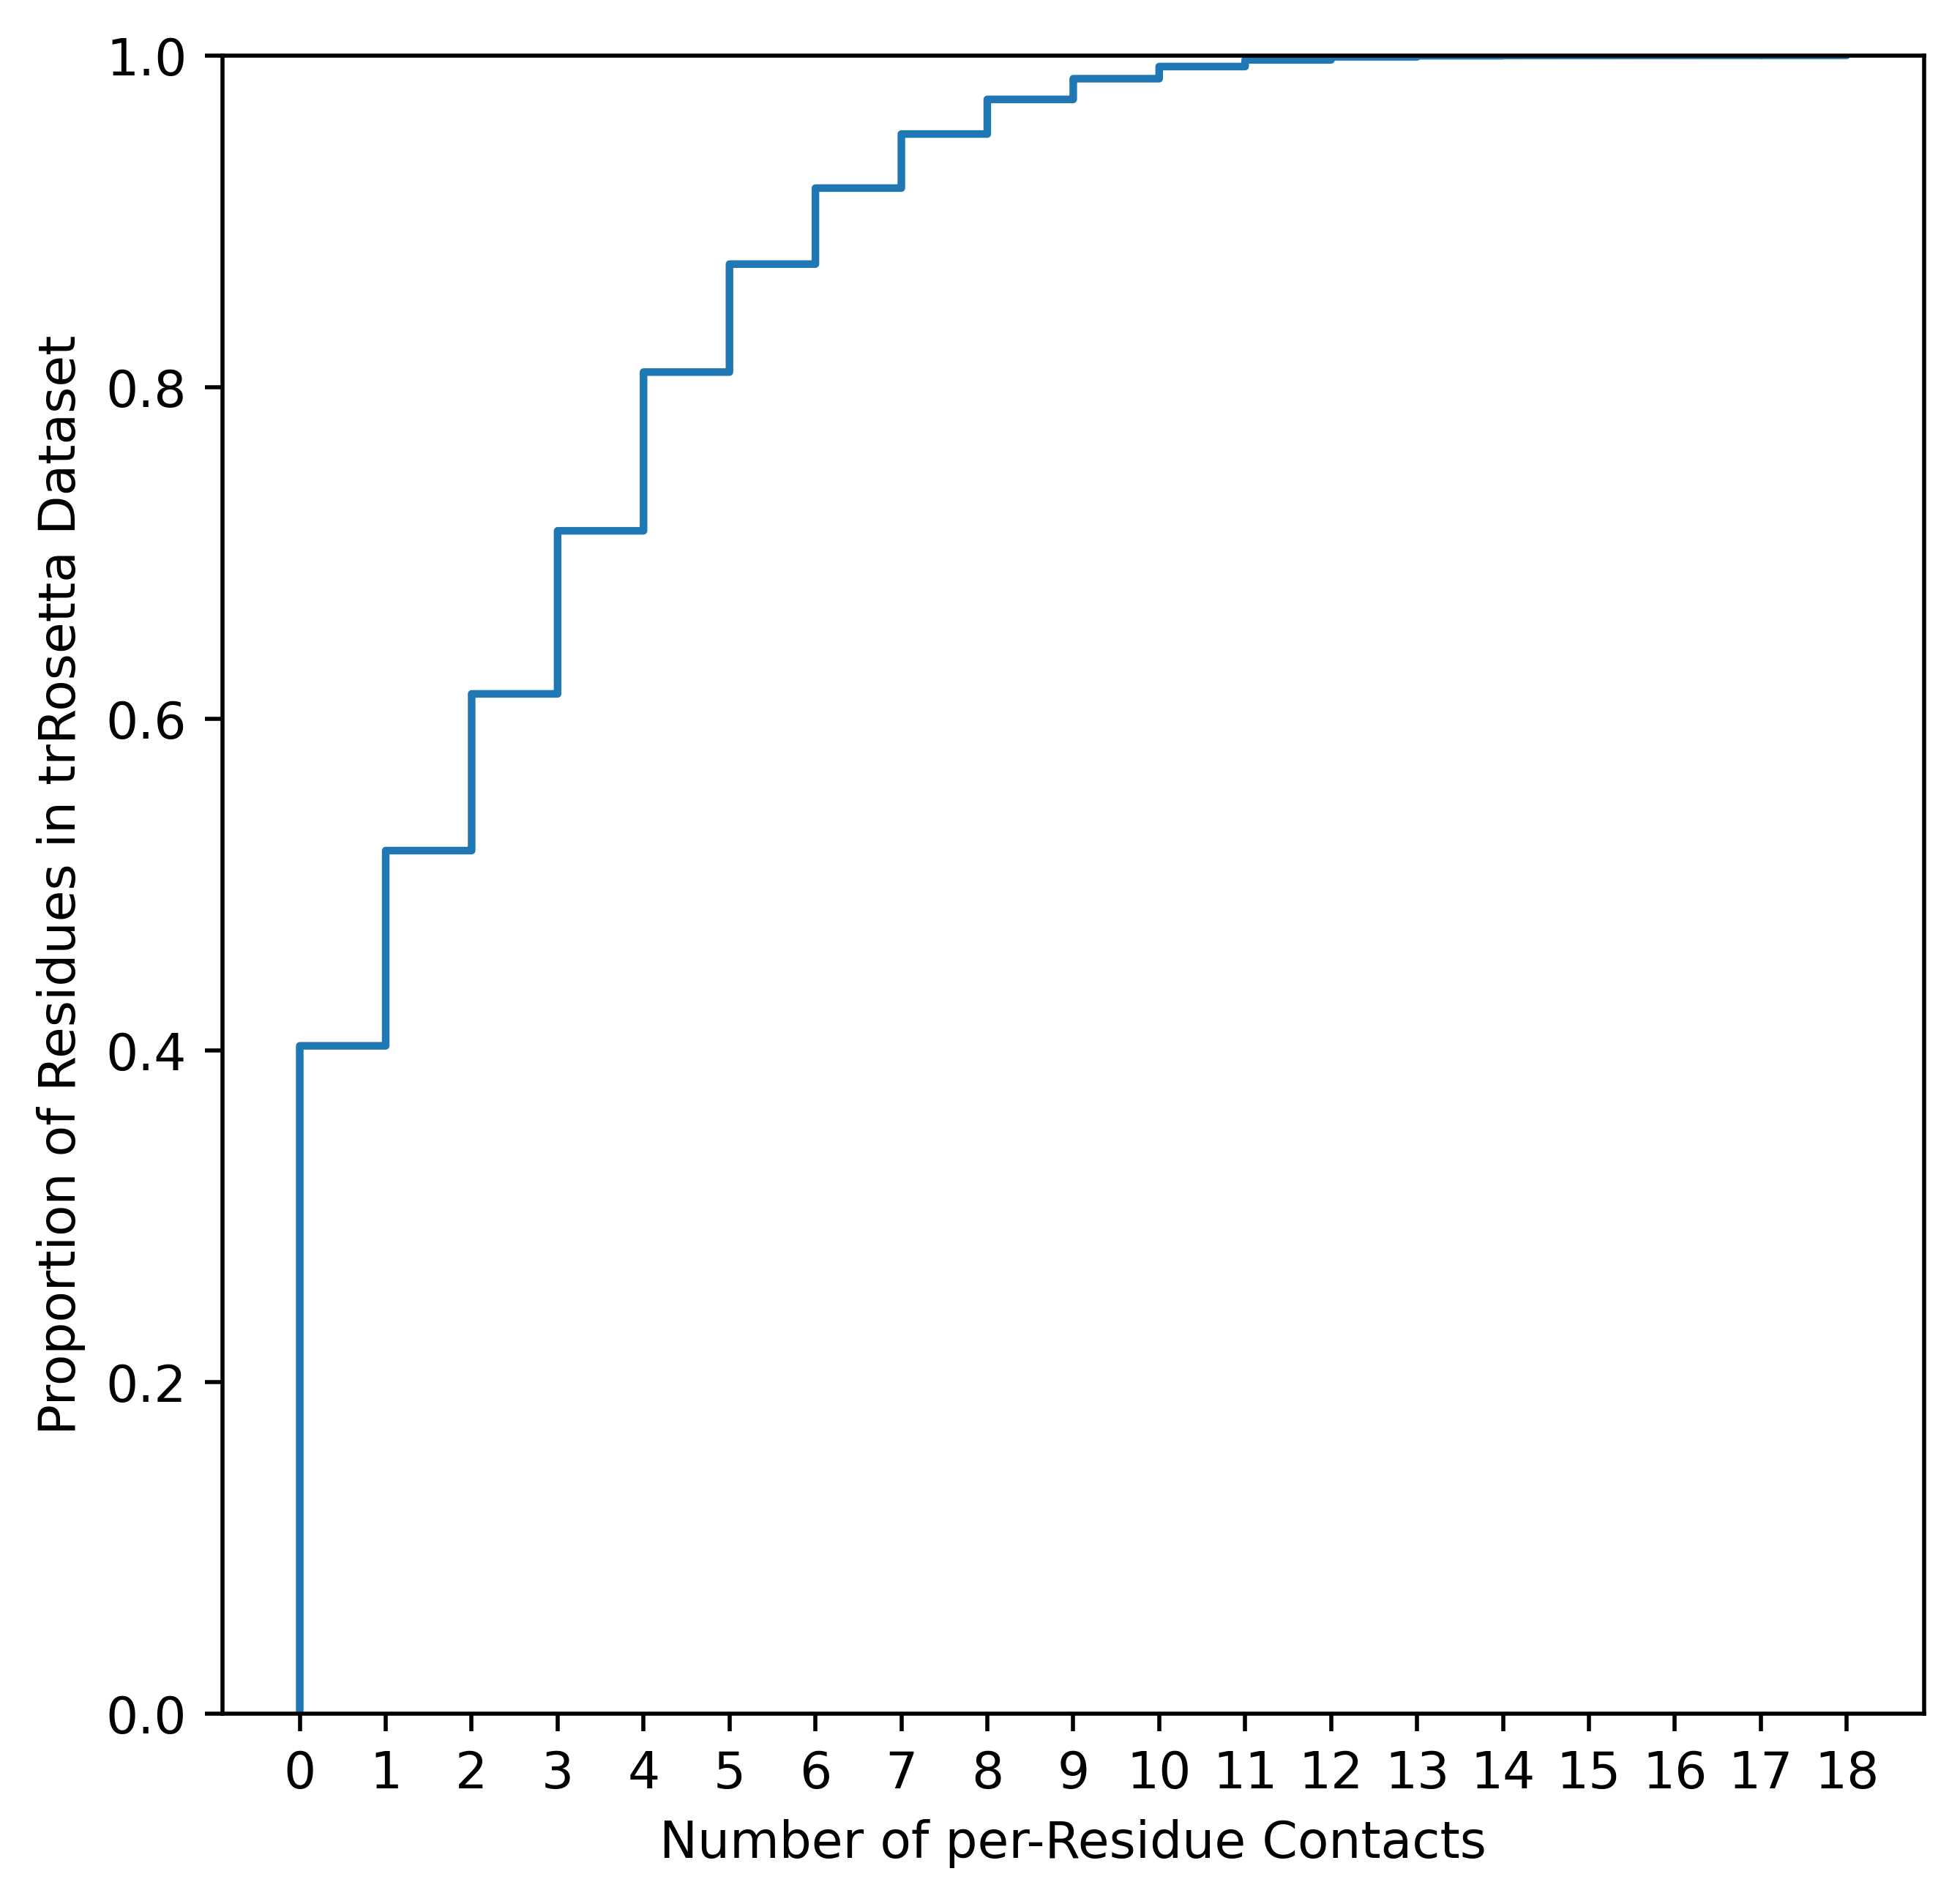

In [185]:
plt.figure(figsize=(6,6), dpi=500)
nbins = contacts_df['num_residue_contacts'].max() + 1
sns.ecdfplot(data=contacts_df, x="num_residue_contacts")
plt.xticks(range(nbins))
plt.xlabel('Number of per-Residue Contacts')
plt.ylabel('Proportion of Residues in trRosetta Dataset')
plt.savefig('ecdf_residue_contacts.pdf', dpi=600, bbox_inches="tight")

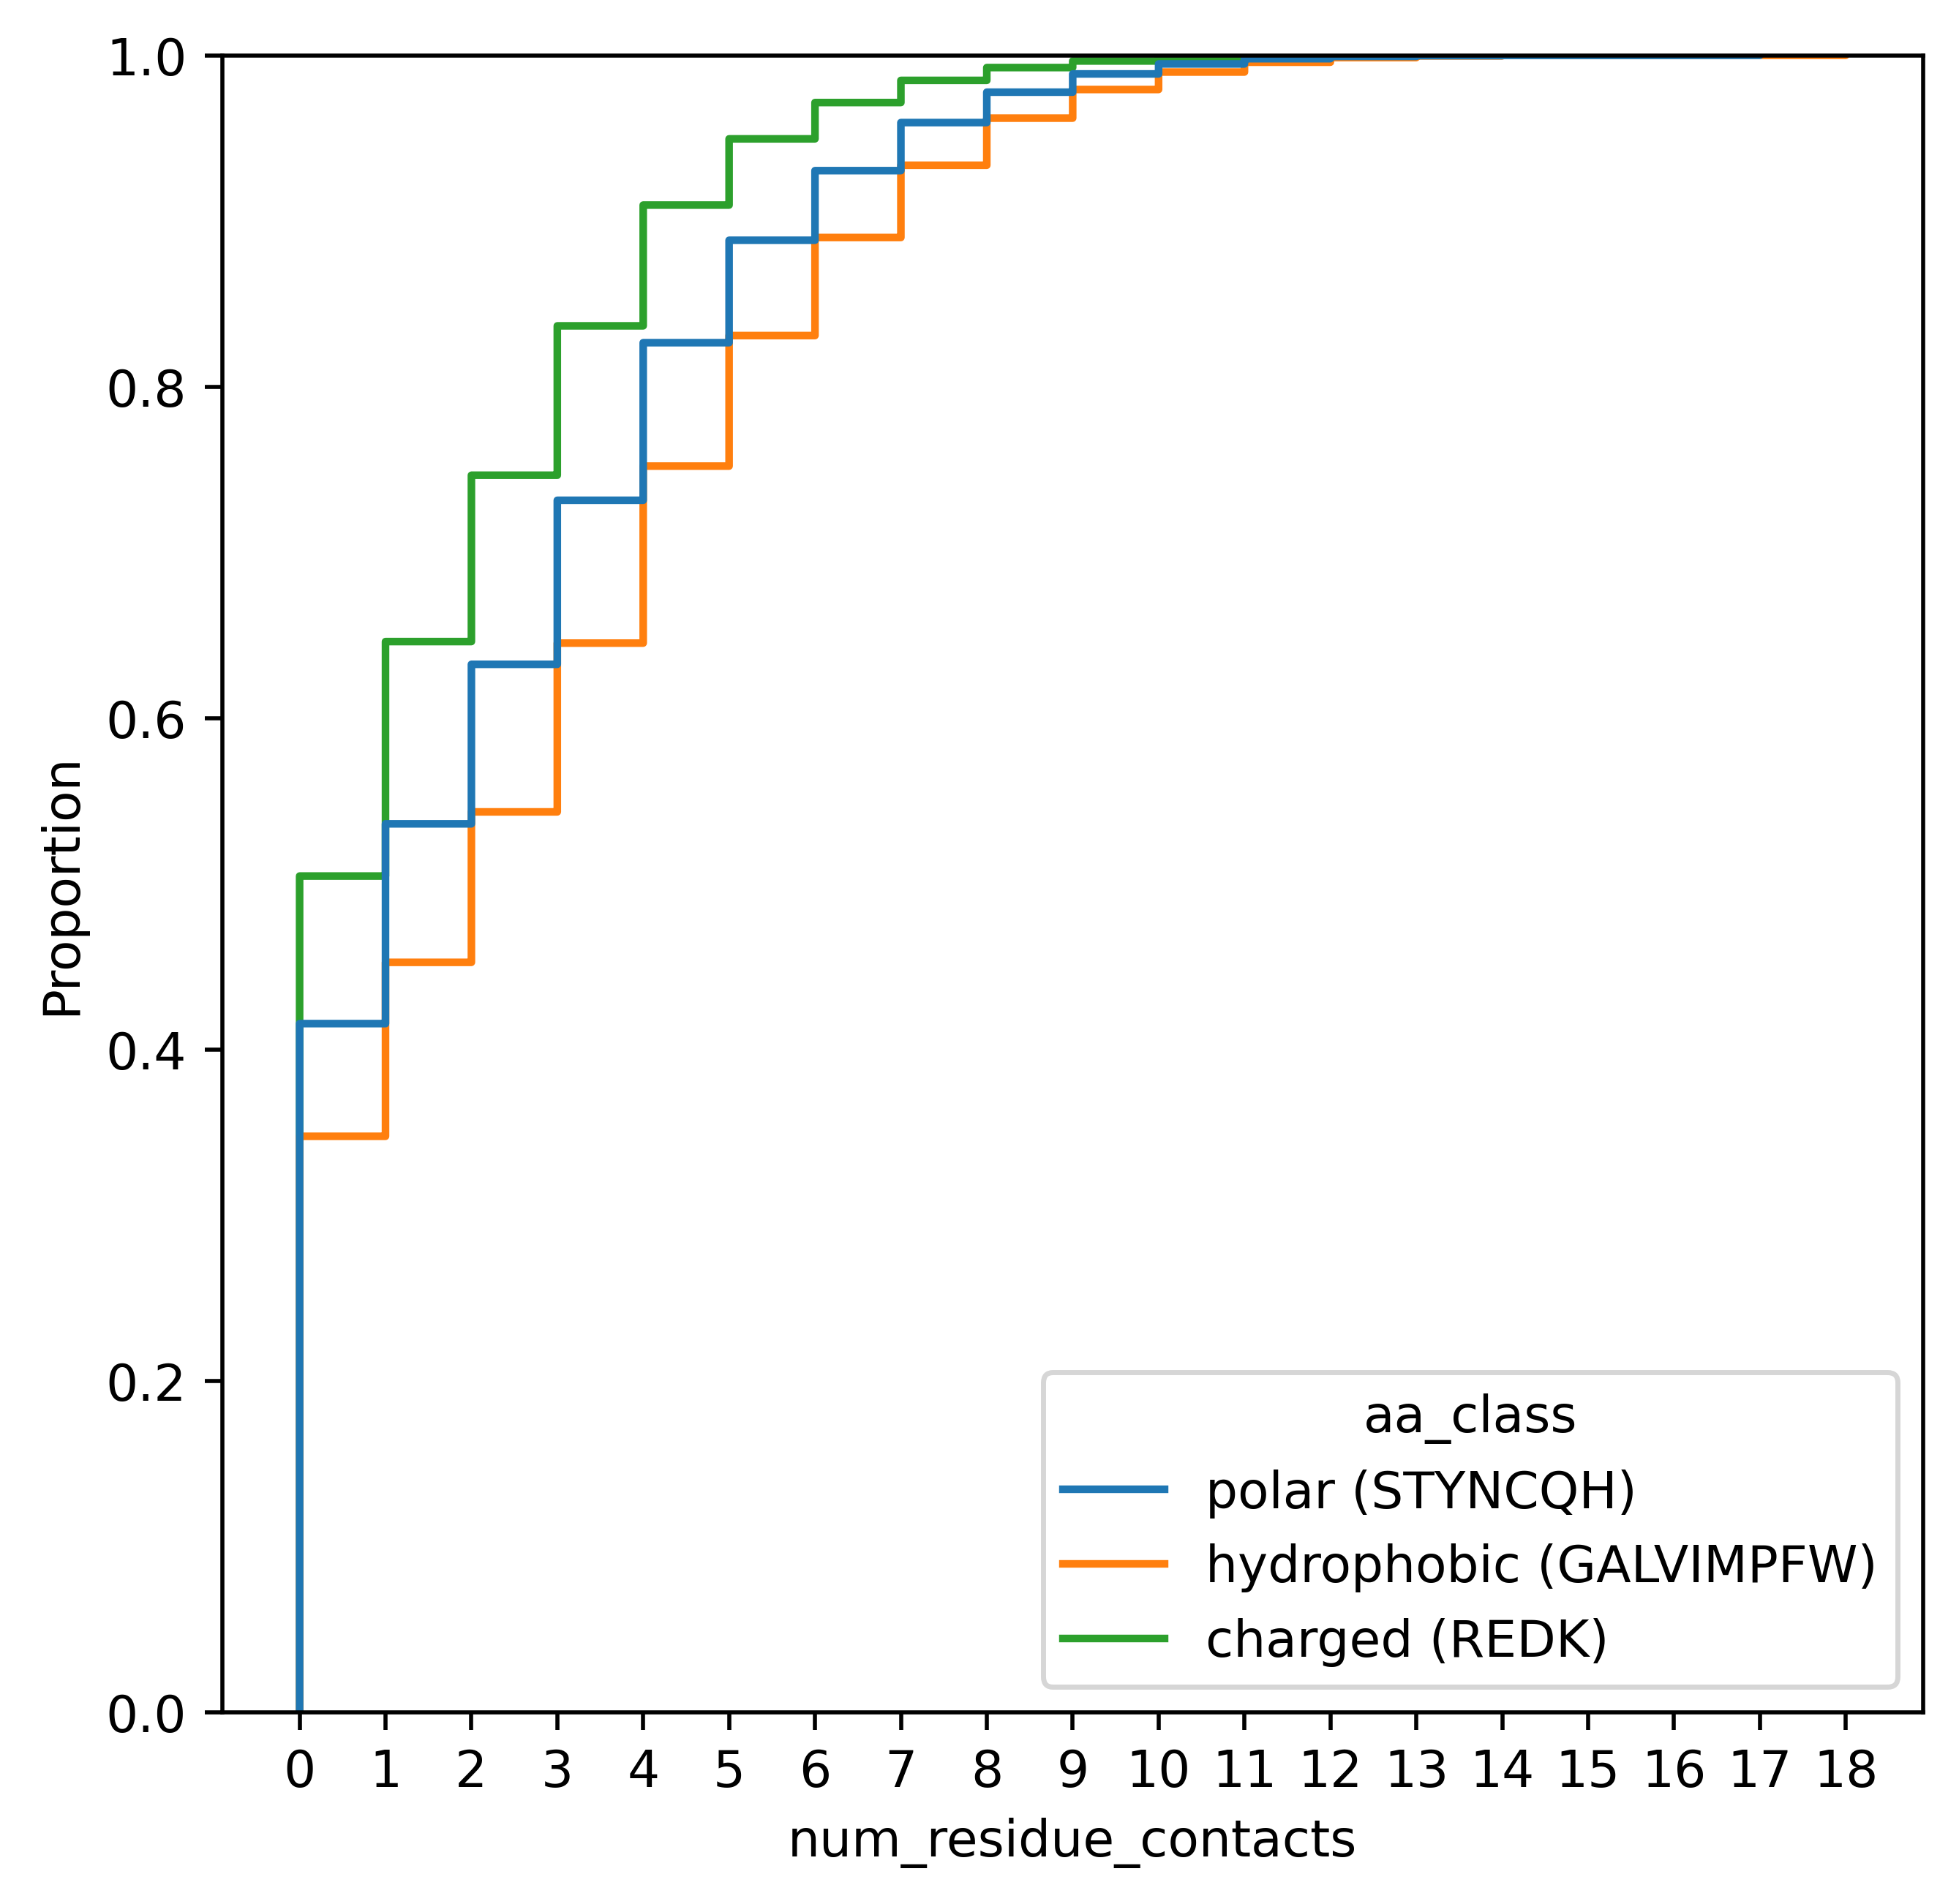

In [190]:
plt.figure(figsize=(6,6), dpi=500)
nbins = contacts_df['num_residue_contacts'].max() + 1
sns.ecdfplot(data=contacts_df, x="num_residue_contacts", hue='aa_class')
plt.xticks(range(nbins))
print('')

In [121]:
 1- g[0][9]

0.017615484610636223

In [126]:
import sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(l.reshape(-1, 1), num_total_contacts)

print(reg.score(l.reshape(-1, 1), num_total_contacts))


0.9290616538968374


2.64


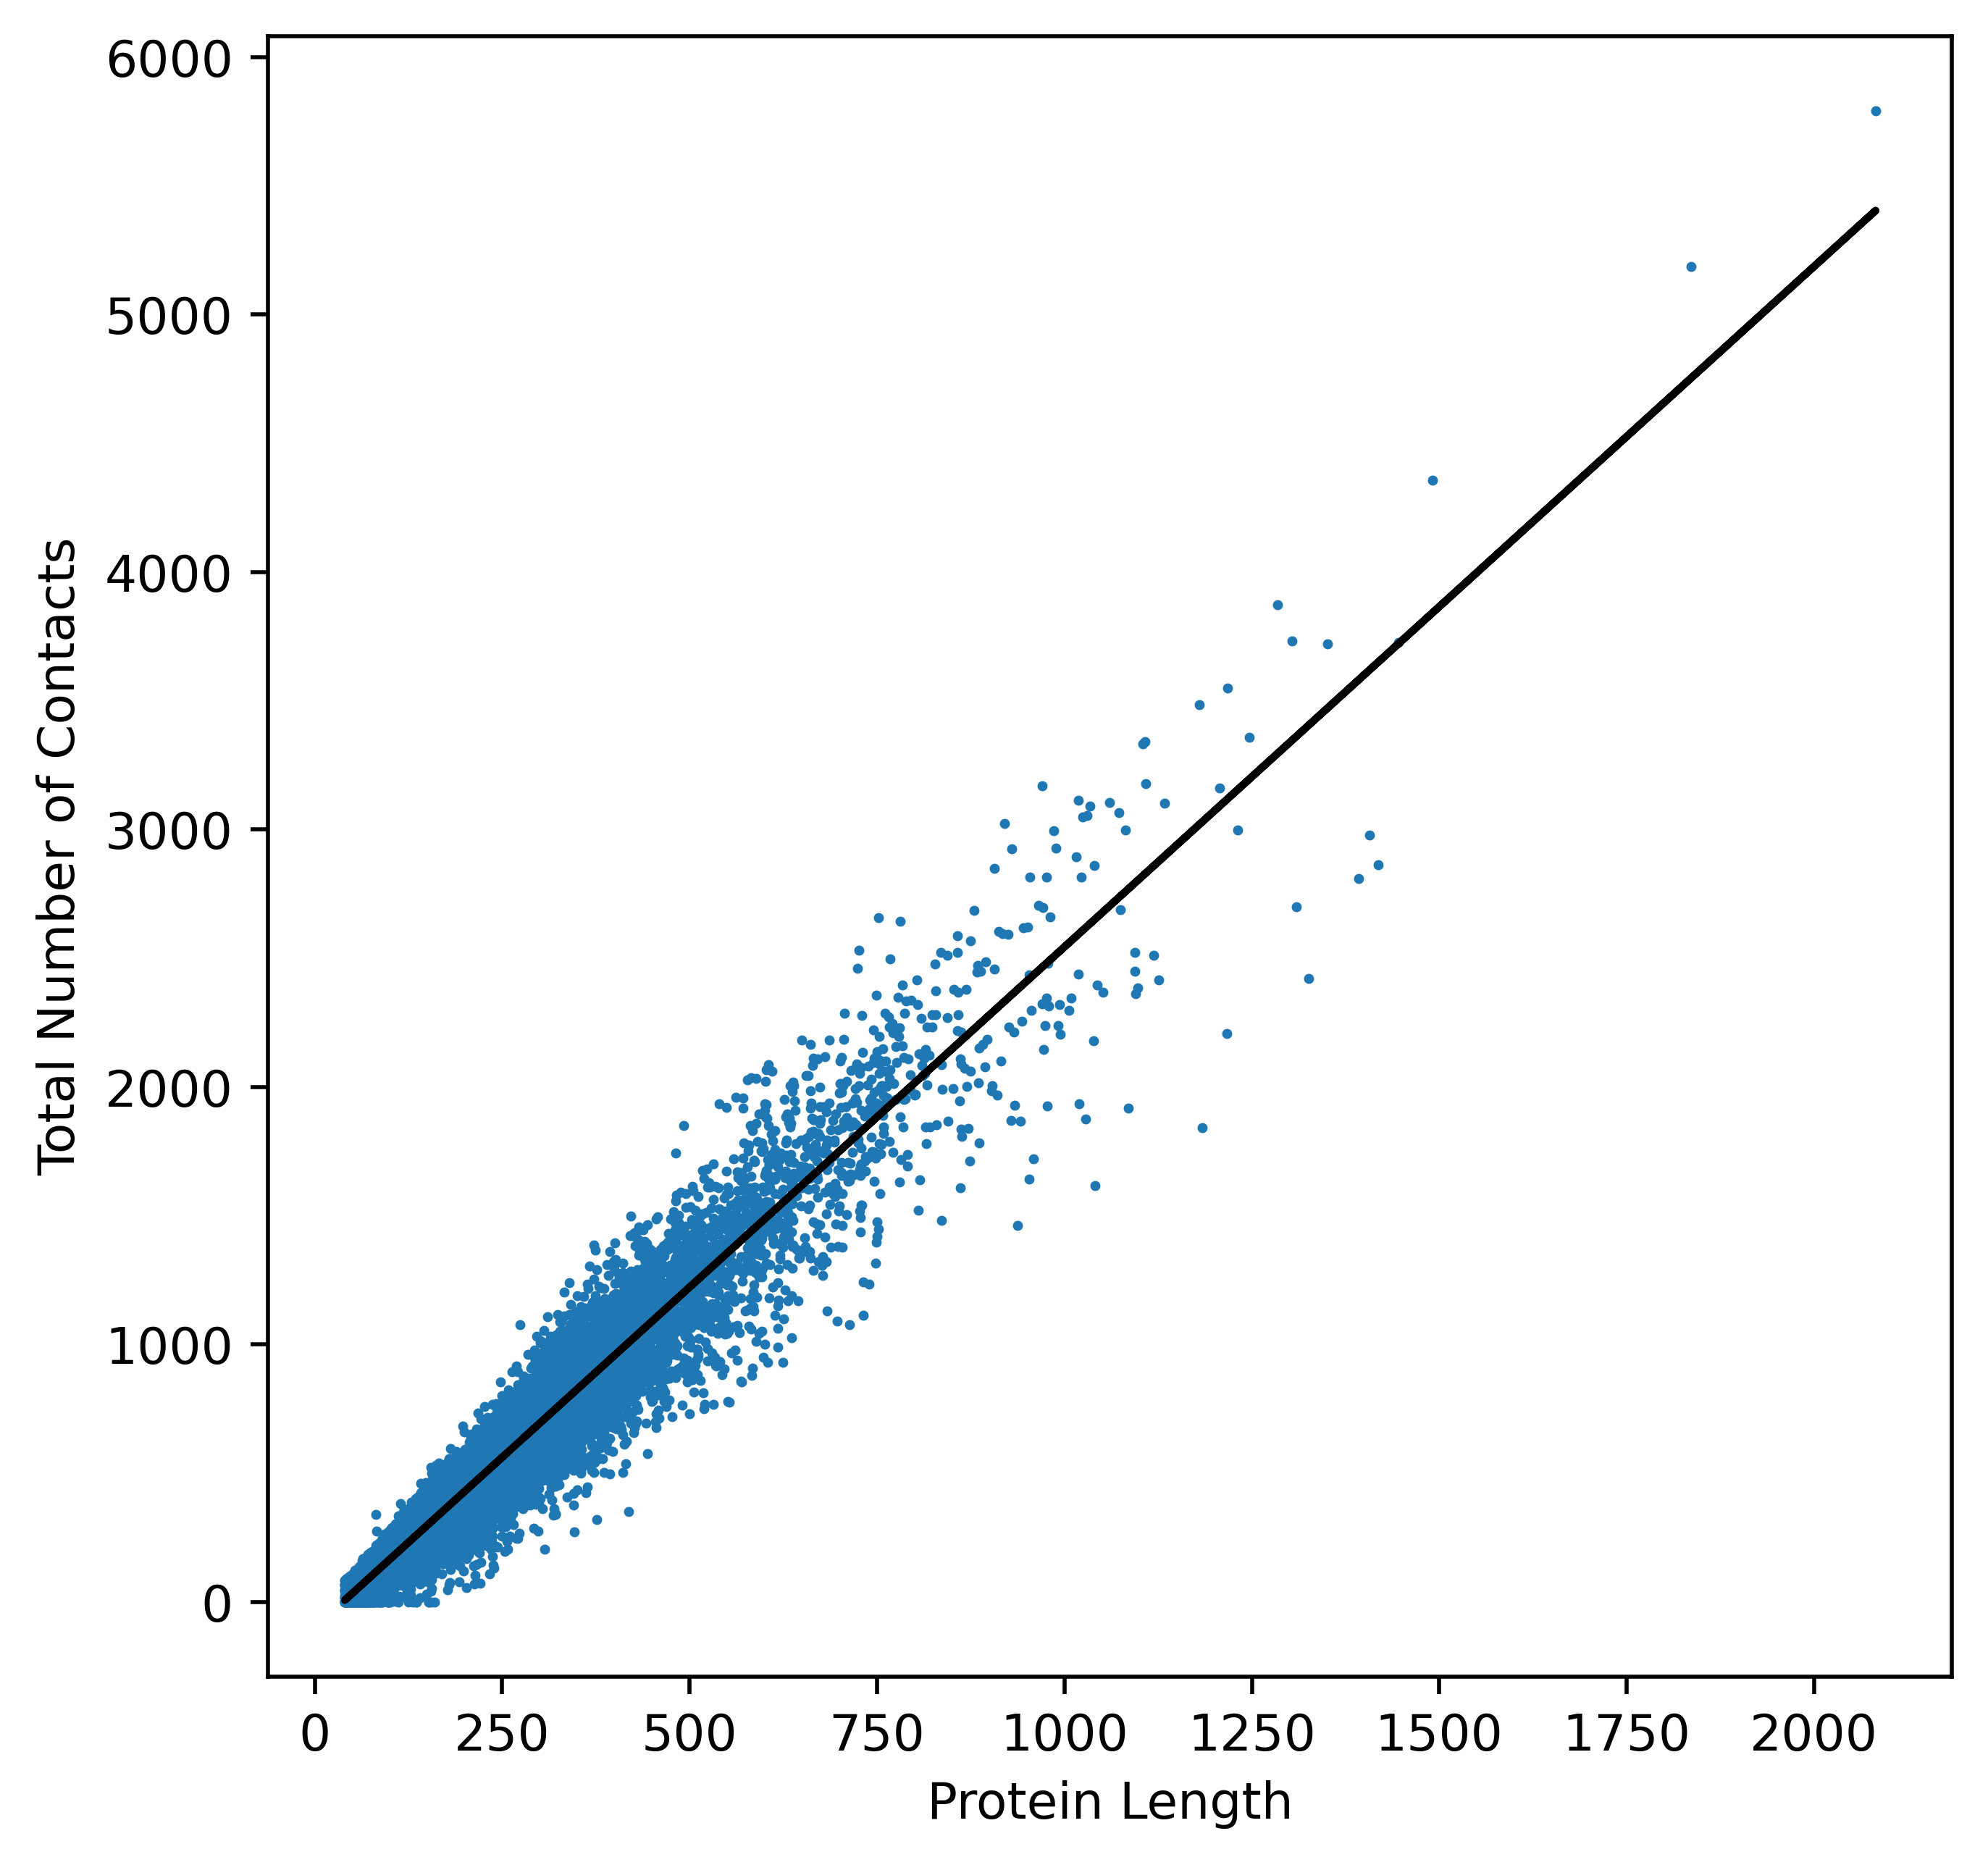

In [123]:
plt.figure(figsize=(6,6), dpi=500)
plt.scatter(l, num_total_contacts, s=1)
plt.plot(l, reg.predict(l.reshape(-1, 1)), color='k')
# plt.ylim(0, 2500)
# plt.xlim(0, 1000)
plt.xlabel('Protein Length')
plt.ylabel('Total Number of Contacts')
print(f'{reg.coef_[0]:.2f}')
# plt.title(f'Contacts grow like {reg.coef_[0]:.2f} L')
plt.savefig('linear_contacts_with_l.pdf', dpi=600, bbox_inches="tight")

In [194]:
deltafams = ['4egc_1_A', '3gq7_1_A', '1jm1_1_A', '4yt2_1_A', '3vmm_1_A', '4k61_1_A', '6fdg_1_A', '4l3r_1_A', '3p6b_1_B', '3cy4_1_B']
gremlin_df[gremlin_df['pdb'].isin(deltafams)].sort_values(by='msa_length')

,sweep_name,model,pdb,msa_length,pdb_idx,num_seqs,run_state,pr_at_L,pr_at_L_apc,pr_at_L_5,pr_at_L_5_apc,auc,auc_apc,use_bias,run_id,attention_head_size,num_attention_heads,log_num_seqs
619,gremlin,gremlin,4k61_1_A,140,128,2145,finished,0.442857,0.557143,0.892857,0.750000,0.816923,0.735086,True,ujksr6sv,-1,-1,7.670895
151,gremlin,gremlin,4l3r_1_A,143,596,5535,finished,0.531469,0.601399,0.642857,0.714286,0.653745,0.690138,True,2mgfaap8,-1,-1,8.618847
524,gremlin,gremlin,3cy4_1_B,154,223,1064,finished,0.259740,0.441558,0.666667,0.666667,0.642828,0.666688,True,ob6lrgxe,-1,-1,6.969791
506,gremlin,gremlin,6fdg_1_A,155,241,2325,finished,0.496774,0.554839,0.774194,0.677419,0.745222,0.720306,True,whwlhwod,-1,-1,7.751475
69,gremlin,gremlin,3p6b_1_B,186,678,4353,finished,0.510753,0.639785,0.783784,0.729730,0.730169,0.718401,True,8se7379b,-1,-1,8.378621
215,gremlin,gremlin,1jm1_1_A,202,532,17130,finished,0.415842,0.519802,0.775000,0.800000,0.727852,0.760259,True,0agw4t5b,-1,-1,9.748587
127,gremlin,gremlin,4yt2_1_A,343,620,15481,finished,0.335277,0.390671,0.602941,0.617647,0.544757,0.566715,True,hfg0si4f,-1,-1,9.647369
468,gremlin,gremlin,3vmm_1_A,471,279,4383,finished,0.484076,0.547771,0.712766,0.712766,0.696527,0.719278,True,t6nrolmu,-1,-1,8.385489
579,gremlin,gremlin,4egc_1_A,539,168,9929,finished,0.480519,0.582560,0.766355,0.794393,0.740791,0.768305,True,s3k5rf0l,-1,-1,9.203215
204,gremlin,gremlin,3gq7_1_A,605,543,6568,finished,0.314050,0.403306,0.619835,0.719008,0.605988,0.678100,True,ib273rxn,-1,-1,8.789965
